## Load libraries

In [37]:
import numpy as np
import sys
import os
import unyt
import caesar
import matplotlib.pyplot as plt

from rennehan.function import sche_func_S
from rennehan.OBSSMF import SMF

from velociraptor.observations.objects import ObservationalData, MultiRedshiftObservationalData
#from astropy.cosmology import WMAP7 as cosmology
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [33]:
cosmology = FlatLambdaCDM(name=r'Flat $\Lambda$CDM', H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
cosmology.name

'Flat $\\Lambda$CDM'

## Load observational data

In [3]:
def bal_gsmf_schec(logM):
    phi_1 = 3.96e-3
    phi_2 = 7.9e-4
    alpha_1 = -0.35
    alpha_2 = -1.47
    M_star = 10.66
            
    dM = logM - M_star

    return np.log(10) * np.exp(-10**dM) * 10**dM * (phi_1 * 10**(dM * alpha_1) + phi_2 * 10**(dM * alpha_2))

OBSSMF: 0 0.2
[-1.51 -1.74 -1.75 -1.37 -1.5  -1.46 -1.56 -1.55 -1.63 -1.72 -1.74 -1.84
 -1.99 -2.02 -2.13 -2.21 -2.24 -2.26 -2.26 -2.29 -2.45 -2.62 -2.9  -3.47
 -4.38 -4.68 -4.38]

[3.63613322 3.33484193 3.07325604 2.84439762 2.64279216 2.46409047
 2.30479808]


Text(0.5, 0, '$\\log M_* [M_\\odot]$')

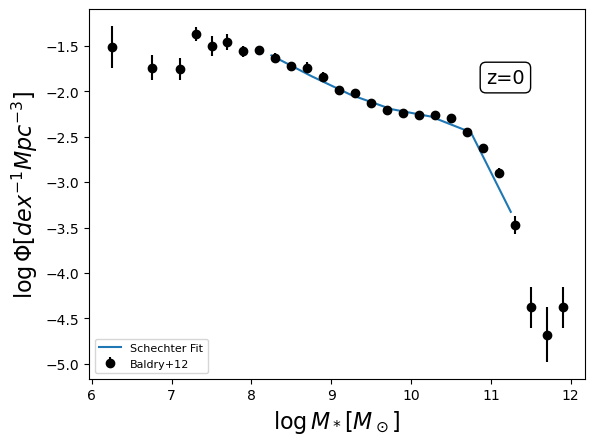

In [57]:
z = 0

# GSMF (data)
smf = SMF(z,name='BalSMF')
print(smf.y)
print()

# GSMF (schechter fit)
dlogM = 0.5
bins = np.arange(8, 11.5+dlogM, dlogM)
#logM_ax = smf.x
#print(logM_ax)
#bin_width = np.array([0.5,0.5,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
#                      0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
logM_ax   = bins[0:-1] + dlogM/2.
Phi = sche_func_S(logM_ax)#/bin_width
print(Phi)

bal_schec = np.log10(bal_gsmf_schec(logM_ax))


# Plot
#if smf.cond and z<0.2: plt.errorbar(smf.x, np.log10((10**smf.y)*bin_width), yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')
if smf.cond and z<0.2: plt.errorbar(smf.x, smf.y, yerr=smf.yerr, fmt='o', label=smf.name, zorder=100, color='k')

plt.plot(logM_ax, bal_schec, ls='-',label='Schechter Fit') 

plt.legend(loc='lower left', prop={'size': 8},fontsize=10)
#plt.annotate('z=%g'%np.round(objs[j].simulation.redshift,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.annotate('z=%g'%np.round(z,0), xy=(0.8, 0.8), xycoords='axes fraction',size=14,bbox=dict(boxstyle="round", fc="w"))
plt.ylabel(r'$\log \Phi [dex^{-1}Mpc^{-3}$]',fontsize=16)
#if irow == nrowmax-1: ax0.set_xlabel(r'$\log M_* [M_\odot]$',fontsize=16)
plt.xlabel(r'$\log M_* [M_\odot]$',fontsize=16)

## Create and save Velociraptor HDF5 data files

In [58]:
unyt.Mpc

Mpc

In [59]:
output_filename = "Baldry12_gsmf_schechter.hdf5"
output_directory = "/home/b/babul/aspadawe/data/gsmf/"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

processed = ObservationalData()

comment = f"Assuming Chabrier (2003) IMF. h-corrected for SWIFT using cosmology: {cosmology.name}."
citation = "Baldry et al. 2012 (GAMA)"
bibcode = "2012MNRAS.421..621B"
name = "GSMF from GAMA"
plot_as = "line"
redshift = 0.0
redshift_lower = 0.0
redshift_upper = 0.06
h = cosmology.h
#print(h)

log_M = logM_ax
#M = 10 ** (log_M) * unyt.Solar_Mass / h
M = 10 ** (log_M) * unyt.Solar_Mass
#Phi = (10**raw.T[1] * (h ** 3)) * unyt.Mpc ** (-3)
Phi = (10**bal_schec) * unyt.Mpc ** (-3) #* unyt.mag ** (-1)

processed.associate_x(M, scatter=None, comoving=True, description="Galaxy Stellar Mass")
processed.associate_y(Phi, scatter=None, comoving=True, description="Phi (GSMF)")
processed.associate_citation(citation, bibcode)
processed.associate_name(name)
processed.associate_comment(comment)
processed.associate_redshift(redshift, redshift_lower, redshift_upper)
processed.associate_plot_as(plot_as)
processed.associate_cosmology(cosmology)

output_path = os.path.join(output_directory, output_filename)

if os.path.exists(output_path):
   os.remove(output_path)

processed.write(filename=output_path)